In [2]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split

[autoreload of numpy._globals failed: Traceback (most recent call last):
  File "/home/mike/.local/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/mike/.local/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/usr/lib/python3.5/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.5/importlib/__init__.py", line 159, in reload
    name=parent_name) from None
ImportError: parent 'numpy' not in sys.modules
]
[autoreload of numpy.core.info failed: Traceback (most recent call last):
  File "/home/mike/.local/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/mike/.local/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/usr/lib/py

ImportError: Missing required dependencies ['numpy']

In [ ]:
# Constants (Feel free to tweek these and observe different outcomes)
ENABLE_DISTRICT_SPLIT = False #This will ensure that schools in the same district are groupped into either trianing, validation or test. Without it they may stradle this
RANDOM_STATE = 10 #This allows for the randomization to be repeatable (can be changed to None to be truely random)
NUM_JOBS = 2 #Number of threads to run on

In [ ]:
#Loading the data with pandas
math = pd.read_csv("../Data/math.csv")
read = pd.read_csv("../Data/read.csv")
business = pd.read_csv("../Data/BUSSINES.csv")
geo = pd.read_csv("../Data/geo.csv", low_memory=False)
funding = pd.read_csv("../Data/FUNDING.csv")
income = pd.read_csv("../Data/income.csv")
teachers = pd.read_csv("../Data/Teacher Ratios.csv")
title1 = pd.read_csv("../Data/title1.csv")
#Set indexs
math = math.set_index("math_ncessch")
read = read.set_index("read_ncessch")
business = business.set_index("zip_code")
funding["ncesid"] = pd.to_numeric(funding["ncesid"], errors="coerce")
funding = funding.set_index("ncesid")
geo = geo.set_index("ncessch")
income = income.set_index("zipcode")
teachers["ncessch"] = teachers["ncessch"].astype(np.int64)
teachers = teachers.set_index("ncessch")
title1["ncessch"] = title1["ncessch"].astype(np.int64)
title1 = title1.set_index("ncessch")

In [ ]:
def fixNumPaidEmployees(e):
    if e == 'b':
        return 59.5
    elif e == 'a':
        return 9.5
    elif e == 'h':
        return 3749.5
    elif e == 'c':
        return 174.5
    elif e == 'i':
        return 7499.5
    elif e == 'f':
        return 749.5
    elif e == 'e':
        return 374.5
    elif e == 'g':
        return 1749.5
    elif e == 'j':
        return 17499.5
    elif e == 'k':
        return 37499.5
    elif e == 'l':
        return 74999.5
    else:
        return e

business['num_paid_employees'] = business['num_paid_employees'].apply(fixNumPaidEmployees)
business = business[business['first_quarter_payroll'] !='D']
business = business[business["annual_payroll"] != 'D']

In [ ]:
business[business["annual_payroll"] != 'D']['annual_payroll']

In [ ]:
#Fix title1 data
title1 = title1[title1['title_i_status'] != 'M']
title1 = title1[title1['title_i_status'] != '-9']
title1 = title1[title1['title_i_eligibility'] != 'Missing']
title1 = title1[title1['title_i_eligibility'] != '-9']
title1 = title1[title1['ntnl_school_lunch_program_status'] != 'MISSING']
title1 = title1[title1['ntnl_school_lunch_program_status'] != '-9']
title1 = title1[title1['school_wide_title_i_eligibility'] != 'Missing']
title1 = title1[title1['school_wide_title_i_eligibility'] != '-9']
title1['ntnl_school_lunch_program_status_Yes'] = title1['ntnl_school_lunch_program_status'].apply(lambda x: 'Yes' in x)
title1 = pd.concat([title1.drop('title_i_eligibility',1),pd.get_dummies(title1["title_i_eligibility"], prefix='title_1_eligbility_')], axis=1)
title1 = pd.concat([title1.drop('school_wide_title_i_eligibility',1),pd.get_dummies(title1["school_wide_title_i_eligibility"], prefix='school_wide_title_i_eligibility')], axis=1)
title1 = pd.concat([title1.drop('ntnl_school_lunch_program_status',1),pd.get_dummies(title1["ntnl_school_lunch_program_status"], prefix='ntnl_school_lunch_program_status')], axis=1)

mathStates = set(math['math_stnam'])
mathStatesPairs = {}
count = 0
for i in mathStates:
    mathStatesPairs[i] = count
    count += 1

#Fix teachers
teachers= teachers[teachers['num_full_time'] >0] 

In [ ]:
#Combines the datasets together. This is similar to SQL's join statements but uses Pandas
combined = math[['math_leaid','math_stnam','math_all_grades_numvalid','math_all_grades_pctprof_low','math_all_grades_pctprof_high']].join([read[['read_all_grades_numvalid','read_all_grades_pctprof_low','read_all_grades_pctprof_high']],geo[['zip','locale','lat','lon']]], how="inner")
combined = combined.join(business[['num_establishments',"num_paid_employees", "first_quarter_payroll", "annual_payroll"]], how="inner", on="zip")
combined = combined.join(funding.drop(["idcensus","name","conum","csa","cbsa","enroll"],1), how="inner", on="math_leaid")
combined = combined.join(income.drop(["statefips",'state'], 1), how="inner", on="zip")
combined = combined.join(teachers["num_full_time"], how="inner")
combined = combined.join(title1[["title_i_status",'ntnl_school_lunch_program_status_Yes', 'title_1_eligbility__No',
       'title_1_eligbility__Not Applicable', 'title_1_eligbility__Yes',
       'school_wide_title_i_eligibility_No',
       'school_wide_title_i_eligibility_Not Applicable',
       'school_wide_title_i_eligibility_Yes',
       'ntnl_school_lunch_program_status_No',
       'ntnl_school_lunch_program_status_Yes, participating without using any Provision or the CEO',
       'ntnl_school_lunch_program_status_Yes, under Community Eligibility Option (CEO)',
       'ntnl_school_lunch_program_status_Yes, under Provision 1',
       'ntnl_school_lunch_program_status_Yes, under Provision 2']], how="inner")
combined = combined.drop(['zip'],1)
combined = combined[combined['math_all_grades_pctprof_low'] >=0]
combined = combined[combined['read_all_grades_pctprof_low'] >=0]
combined['math_full_time'] = combined['math_all_grades_numvalid']/combined['num_full_time']
combined['read_full_time'] = combined['read_all_grades_numvalid']/combined['num_full_time']

def convertStatesToNum(i):
    return mathStatesPairs[i] 
combined['stnam'] = combined['math_stnam'].apply(convertStatesToNum)
combined = combined.drop('math_stnam', 1)

In [ ]:
combined['stnam'].describe()

In [ ]:
def boxBySchoolDistrict(df):
    entryGroups = []
    groups = df.groupby('math_leaid')
    for name, entry in groups:
        entryGroups.append(entry)
    return entryGroups
def unbox(entryGroups):
    df = pd.DataFrame()
    return pd.concat(entryGroups)

# Grouping by school districts
The above code groups the data by school district to ensure that each school in a school district is either in the training, test or validation data. If this is not enabled then one school from the district may be in the training, another in the test group and one in the validation group. This is important because some of the data relies on school districts rather than individual schools this ensures that the models are learning the trends not just memorizing what happened at other schools. Untimatly, it is up to the user to determine the importance of this.

In [8]:
if ENABLE_DISTRICT_SPLIT:
    math_train_val, math_test,  = train_test_split(boxBySchoolDistrict(combined), test_size = .2, train_size = .8, random_state =RANDOM_STATE )
else:
    math_train_val, math_test,  = train_test_split(combined, test_size = .2, train_size = .8, random_state =RANDOM_STATE )
math_train, math_val = train_test_split(math_train_val, test_size = .3, train_size = .7, random_state =RANDOM_STATE )
def SplitValuesMath(math):
    if ENABLE_DISTRICT_SPLIT:
        math = unbox(math)
    math_y = (math['math_all_grades_pctprof_low']+math['math_all_grades_pctprof_high'])/2
    math_x = math.drop(['math_leaid',"math_all_grades_pctprof_low","math_all_grades_pctprof_high","read_all_grades_pctprof_low","read_all_grades_pctprof_high"],1)
    return math_x, math_y
math_X_train, math_y_train = SplitValuesMath(math_train)
math_X_val, math_y_val = SplitValuesMath(math_val)
math_X_test, math_y_test = SplitValuesMath(math_test)

In [9]:
if ENABLE_DISTRICT_SPLIT:
    read_train_val, read_test,  = train_test_split(boxBySchoolDistrict(combined), test_size = .2, train_size = .8, random_state =RANDOM_STATE )
else:
    read_train_val, read_test,  = train_test_split(combined, test_size = .2, train_size = .8, random_state =RANDOM_STATE )
read_train, read_val = train_test_split(read_train_val, test_size = .3, train_size = .7, random_state =RANDOM_STATE )
def SplitValuesMath(read):
    if ENABLE_DISTRICT_SPLIT:
        read = unbox(read)
    read_y = (read['math_all_grades_pctprof_low']+read['math_all_grades_pctprof_high'])/2
    read_x = read.drop(['math_leaid',"math_all_grades_pctprof_low","math_all_grades_pctprof_high","read_all_grades_pctprof_low","read_all_grades_pctprof_high"],1)
    return read_x, read_y
read_X_train, read_y_train = SplitValuesMath(read_train)
read_X_val, read_y_val = SplitValuesMath(read_val)
read_X_test, read_y_test = SplitValuesMath(read_test)

In [10]:
def performGridSearch(x_train, y_train, x_val, y_val, depths):
    max_score = (0,0)
    for depth in depths:
        print("running with max depth", depth)
        rfr = RandomForestRegressor(n_estimators = 10, max_depth=depth, random_state=RANDOM_STATE)
        trained = rfr.fit(x_train, y_train)
        score = rfr.score(x_val, y_val)
        if score > max_score[1]:
            max_score = (depth, score)
    return max_score[1]
optimal_depth_math = performGridSearch(math_X_train, math_y_train, math_X_val, math_y_val, range(1, 2))
optimal_depth_read = performGridSearch(read_X_train, read_y_train, read_X_val, read_y_val, range(1, 2))

running with max depth 1
running with max depth 1


KeyboardInterrupt: 

In [12]:
rfr_math = RandomForestRegressor(n_estimators=100, max_depth=19, random_state=RANDOM_STATE)
trained = rfr_math.fit(math_X_train, math_y_train)
print("Math", rfr_math.score(math_X_test, math_y_test))

rfr_read = RandomForestRegressor(n_estimators=100, max_depth=19, random_state=RANDOM_STATE)
trained = rfr_read.fit(read_X_train, read_y_train)
print("Read",rfr_read.score(read_X_test, read_y_test))

Math 0.6716825081895442
Read 0.6716825081895442


In [13]:
def calculateDelta(x_test, y_test,estimator):
    #Calculates the distance from the predicted value to the actual value
    predictions = np.array(estimator.predict(x_test))
    return np.absolute(predictions - y_test)
print("Math Delta", np.mean(calculateDelta(math_X_test, math_y_test, rfr_math)))
print("Reading Delta", np.mean(calculateDelta(read_X_test, read_y_test, rfr_read)))

Math Delta 9.775039893376452
Reading Delta 9.775039893376452


Text(0.5, 0, 'Error')

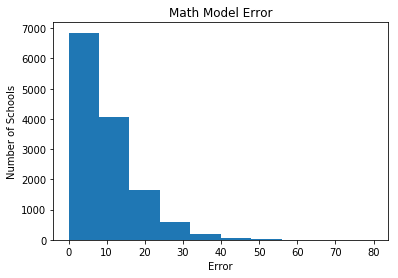

In [18]:
#calculateDelta(math_X_test, math_y_test, rfr_math)
#pd.Series(calculateDelta(math_X_test, math_y_test, rfr_math)).describe()
plt.hist(calculateDelta(math_X_test, math_y_test, rfr_math))
plt.title("Math Model Error")
plt.ylabel("Number of Schools")
plt.xlabel("Error")
#print("Math max Delta", maxDelta(math_X_test, math_y_test, rfr_math))
#print("Reading max Delta", maxDelta(read_X_test, read_y_test, rfr_read))


Text(0.5, 0, 'Error')

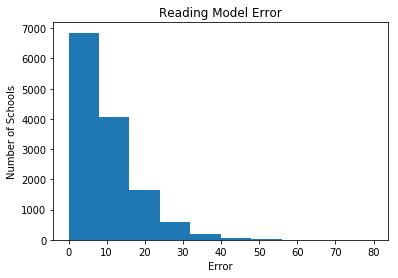

In [22]:
#calculateDelta(math_X_test, math_y_test, rfr_math)
#pd.Series(calculateDelta(math_X_test, math_y_test, rfr_math)).describe()
plt.hist(calculateDelta(read_X_test, read_y_test, rfr_read))
plt.title("Reading Model Error")
plt.ylabel("Number of Schools")
plt.xlabel("Error")
#print("Math max Delta", maxDelta(math_X_test, math_y_test, rfr_math))
#print("Reading max Delta", maxDelta(read_X_test, read_y_test, rfr_read))


In [119]:
features = pd.DataFrame({'scores':rfr_math.feature_importances_, 'names':math_X_train.columns})
features.sort_values(by='scores', ascending=False)

,names,scores
0,math_all_grades_numvalid,0.0
1,read_all_grades_numvalid,0.0
88,state_local_general_amount,0.0
87,num_return_state_local_general,0.0
86,education_expense_amount,0.0
85,num_educator_expenses,0.0
84,unemployeement_amount,0.0
83,num_returns_unemployeement,0.0
82,business_professional_amount,0.0
81,num_business_professional,0.0


In [120]:
features = pd.DataFrame({'scores':rfr_read.feature_importances_, 'names':read_X_train.columns})
features.sort_values(by='scores', ascending=False)

,names,scores
0,math_all_grades_numvalid,0.0
1,read_all_grades_numvalid,0.0
88,state_local_general_amount,0.0
87,num_return_state_local_general,0.0
86,education_expense_amount,0.0
85,num_educator_expenses,0.0
84,unemployeement_amount,0.0
83,num_returns_unemployeement,0.0
82,business_professional_amount,0.0
81,num_business_professional,0.0
